# Stratified K Fold cross-validation

Using KNN dataset to implement stratified K Fold cross-validation 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

Clear previously loaded data.


In [71]:
# read in the iris data
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

# Visualize the dataset

In [72]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


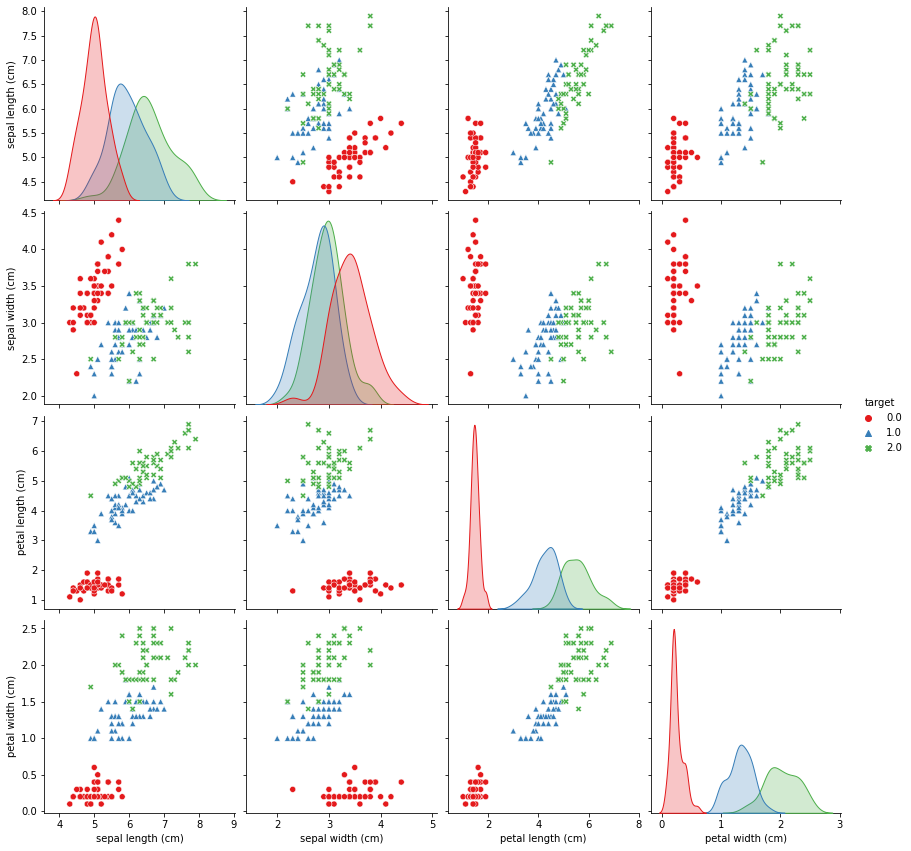

In [73]:
sns.color_palette("hls", 8)

sns.pairplot(data=iris_df,
             hue="target",
             height = 3,
            markers=["o", "^", "X"],
            palette = "Set1")# or 'Set2' or 'pastel'

# Test train split

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42, stratify=y)

print(y_train.shape)

(120,)


# Stratified K-fold naive implementation

In [75]:
def stratified_split(X_train, y_train, num_folds):
    
    y_new = []
    X_new = []
    y_train_nfold = []
    X_train_nfold = []
    y_train_fold = []
    X_train_fold = []
    
    # Number of classes
    Classes = np.unique(y_train)
    
    # Sorting training set for target values
    idx_sort = y_train.argsort()

    y_train_sort = np.array_split(y_train[idx_sort],len(Classes))
    X_train_sort = np.array_split(X_train[idx_sort],len(Classes))
    
    #splitting training data into sub arrays of n-folds
    for i in range(len(y_train_sort)):
        y_new.append( np.array_split(y_train_sort[i], num_folds) )
        X_new.append( np.array_split(X_train_sort[i], num_folds) )
        
    for i in range(len(y_new[:][0])):
        temp = []
        temp2 = []
        for j in range(len(y_train_sort)):
            temp.append(y_new[j][i])
            temp2.append(X_new[j][i])
        y_train_nfold.append(temp)
        X_train_nfold.append(temp2)
        
    for i in range(len(y_train_nfold)):
        y_train_fold.append(np.concatenate( (y_train_nfold[i]) ))
        X_train_fold.append(np.concatenate( (X_train_nfold[i]) ))
        
    return X_train_fold, y_train_fold
    

In [76]:
from classifiers import KNearestNeighbor

k_choices = sorted([1, 3, 5, 8, 10, 12, 15, 20, 50])
num_folds = 5

k_accuracy = {}
X_train_folds = []
y_train_folds = []

classifier = KNearestNeighbor()

X_train_folds, y_train_folds = stratified_split(X_train, y_train, num_folds)

for k in k_choices:
    lst1 = []
    knn = KNeighborsClassifier(n_neighbors=k)
    
    for f in range(num_folds):  
        X_train_copy = X_train_folds.copy()
        y_train_copy = y_train_folds.copy()
        X_temp_val = X_train_copy.pop(f)
        y_temp_val = y_train_copy.pop(f)
        X_temp_tr = np.concatenate( (X_train_copy), axis=0 )
        y_temp_tr = np.concatenate( (y_train_copy), axis=0 )
        
        classifier.train(X_temp_tr, y_temp_tr)
        y_val_pred = classifier.predict(X_temp_val, k)
        
        # Compute and print the fraction of correctly predicted examples
        num_val = y_temp_val.shape[0]
        num_correct = np.sum(y_temp_val == y_val_pred)
        accuracy = float(num_correct) / num_val
        lst1.append(accuracy)
            
    k_accuracy[k] = lst1

k_accuracy

{1: [0.875, 1.0, 1.0, 0.9583333333333334, 0.9583333333333334],
 3: [0.9166666666666666, 1.0, 1.0, 0.9583333333333334, 0.9583333333333334],
 5: [0.875, 1.0, 1.0, 0.9583333333333334, 0.9583333333333334],
 8: [0.875, 1.0, 1.0, 1.0, 1.0],
 10: [0.8333333333333334, 1.0, 1.0, 1.0, 1.0],
 12: [0.9166666666666666, 1.0, 1.0, 0.9583333333333334, 1.0],
 15: [0.9166666666666666, 1.0, 1.0, 0.875, 1.0],
 20: [0.875, 1.0, 0.9583333333333334, 0.9166666666666666, 1.0],
 50: [0.8333333333333334, 1.0, 0.9166666666666666, 0.875, 0.875]}

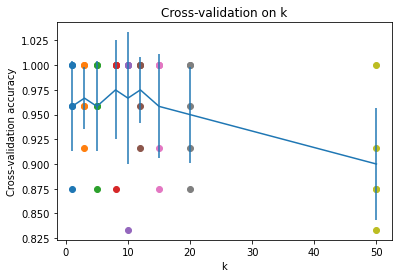

In [77]:
# plot the raw observations
for k in k_choices:
    accuracies = k_accuracy[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracy.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_accuracy.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [78]:
# Based on the cross-validation results above, choose the best value for k
best_k = k_choices[np.argmax(accuracies_mean)]
print("Best k is:",best_k)
print("Cross validation accuracy:",np.max(accuracies_mean))

Best k is: 8
Cross validation accuracy: 0.975


## Report the final results on test data

In [79]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9666666666666667


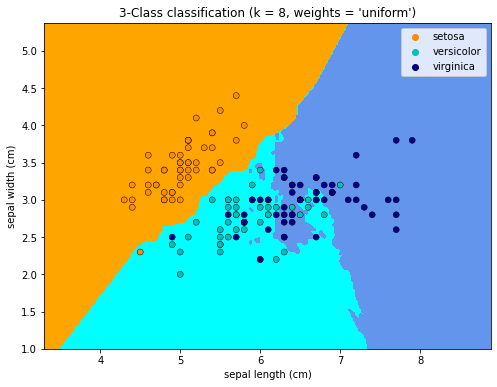

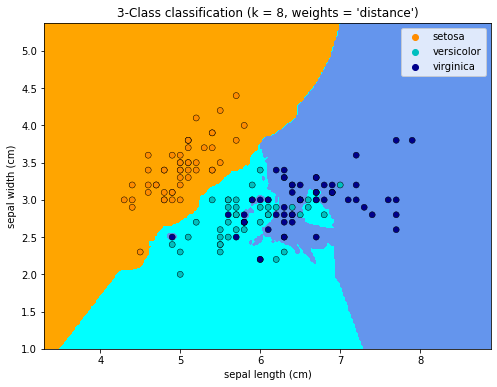

In [80]:
from matplotlib.colors import ListedColormap
import seaborn as sns

n_neighbors = best_k

X = iris.data[:, :2]
y = iris.target

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

# Implementing Stratified K-fold using sklearn

In [85]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

Clear previously loaded data.


In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42, stratify=y)

print(y_train.shape)

(120,)


In [87]:
# Using Sklearn for stratified n-fold - StratifiedKFold
from sklearn.model_selection import StratifiedKFold, KFold

skf = StratifiedKFold()
skf.get_n_splits(X_train, y_train)
k_choices = sorted([1, 3, 5, 8, 10, 12, 15, 20, 50])

k_accuracy = {}
count = 0

for k in k_choices:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    accuracy = []
    for train_index, val_index in skf.split(X_train, y_train):
#         print("TRAIN:", train_index, "TEST:", val_index)
        X_tr, X_val = X[train_index], X[val_index]
        y_tr, y_val = y[train_index], y[val_index]
        
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_val)
        
        accuracy.append(metrics.accuracy_score(y_val, y_pred))
    k_accuracy[k] = accuracy
    
print(k_accuracy)

{1: [1.0, 0.9166666666666666, 0.7083333333333334, 0.7083333333333334, 0.20833333333333334], 3: [1.0, 0.9166666666666666, 0.6666666666666666, 0.875, 0.20833333333333334], 5: [1.0, 0.9166666666666666, 0.8333333333333334, 0.75, 0.20833333333333334], 8: [1.0, 0.9166666666666666, 0.9166666666666666, 0.9583333333333334, 0.20833333333333334], 10: [1.0, 1.0, 0.7916666666666666, 0.9166666666666666, 0.20833333333333334], 12: [1.0, 1.0, 0.8333333333333334, 0.9583333333333334, 0.20833333333333334], 15: [1.0, 1.0, 0.7916666666666666, 0.75, 0.20833333333333334], 20: [1.0, 0.9583333333333334, 0.8333333333333334, 0.7916666666666666, 0.20833333333333334], 50: [0.875, 0.8333333333333334, 0.8333333333333334, 0.625, 0.16666666666666666]}


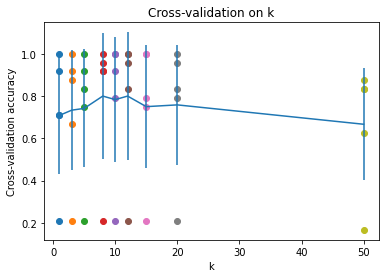

In [89]:
# plot the raw observations
for k in k_choices:
    accuracies = k_accuracy[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracy.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_accuracy.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [88]:
# Based on the cross-validation results above, choose the best value for k
best_k = k_choices[np.argmax(accuracies_mean)]
print("Best k is:",best_k)
print("Cross validation accuracy:",np.max(accuracies_mean))

Best k is: 8
Cross validation accuracy: 0.975


In [90]:
# Checking result on testing data
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8
